In [1]:
from dengo_freefall import *

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


 using cli
 using CLI for selections


In [2]:
def Init_values(temperature, density, n_species = 9, cooling=True, size=10):
    """ Create a initial value dictionary,
        for a given temperature, density, number of species
    Args:
        temperature -- in Kelvin
        density     -- in amu / cm**3
        n_species   -- number of species (6/9)
        cooling

    Returns:
        init_values: initial value dictionary with
                     self-consistent energy/ electron density
        primordial : chemical_network classes

    """

    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()
    primordial.threebody = 4

    if n_species == 9:
        for i in range(22):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass
    else:
        for i in range(6):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass

    # the temperature array required to interpolates the rates
    primordial.init_temperature((1e0, 1e5))

    tiny = 1.0e-20

    # init_array are is in fractional abundances
    init_values = dict()
    density = numpy.array([density])*numpy.ones((size))
    if n_species == 6:
        # 6-species model
        init_values["He_1"]    = density * (1.0 - 0.76)
        init_values["He_2"]    = np.array([tiny])
        init_values["He_3"]    = np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = np.array([tiny]) 
    else:
        # 9-species model
        init_values["He_1"]    = density * (1.0 - 0.76) 
        init_values["He_2"]    = density *np.array([tiny])
        init_values["He_3"]    = density *np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = density *np.array([tiny])

        init_values["H_m0"]    = density *np.array([tiny])
        init_values["H2_1"]    = density *np.array([tiny])
        init_values["H2_2"]    = density *np.array([tiny])

    # now everything in mass density
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)

    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init_values[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    init_values['T'] = numpy.array([temperature])*numpy.ones((size))
    ge_array = numpy.ones((size))
    init_values['ge'] = ge_array
    
    # calculate gammaH2
    
    for i in range(size):
        
        temperature = init_values['T'][i]
        x = 6100.0/temperature
        expx = numpy.exp(x)
        gammaH2 = 2.0 / (5.0 + 2.0*x*x*expx / (expx - 1 )**2.0 ) + 1

        rs = primordial.required_species
        H2_1_sp = list(rs)[0]
        gammaH2 = primordial.species_gamma(H2_1_sp,name=False, temp=True).subs({'T':temperature})

        new_num_den = {}
        for ele in num_den.keys():
            new_num_den[ele] = num_den[ele][i]
        
        gamma_factor = primordial.gamma_factor().subs(new_num_den).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T': temperature })

        ge  = ((temperature *  kboltz) *gamma_factor
                             / (init_values['density'][i] * mh  ))

        
        T = init_values['density']*ge*mh / kboltz / gamma_factor
        init_values['ge'][i] = numpy.float64(ge)
    print(ge)
    if cooling:
        for cooling_action in cooling_registry:
            k = cooling_registry[cooling_action]
            if (k.species).issubset( primordial.required_species ):
                if k.name != "cie_cooling":                    
                    print("adding cooling: {}".format(k.name) )
                    primordial.add_cooling(cooling_action)
    return init_values, primordial

In [3]:
density = 1e10
initial_temperature = 2000.0
final_time = 1e10

final_time_Myr = u.second.in_units('Myr').v * final_time

init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True, size=1)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [121]:
solver_name = 'test_bechem_cvdls'
pyximport.install(setup_args={"include_dirs":np.get_include()},
                  reload_support=True, inplace=True)

primordial.stop_time = 1.0e10
# write the network

# primordial.write_solver(solver_name, output_dir = ".",
#     solver_template = "be_chem_solve/rates_and_rate_tables",
#     ode_solver_source = "BE_chem_solve.C",
#     init_values=init,
#     input_is_number=False)

# import the pyx module
bechem_cvdls_run = pyximport.load_module("{}_run".format(solver_name),
                "{}_solver_run.pyx".format(solver_name),
                 build_inplace = True, pyxbuild_dir = "_dengo_temp")

In [122]:
temperature = 50000.0# K
density = 1.0e-1*1.007947 # cm^-3


init, primordial = Init_values(temperature, 
                               density, n_species = 9, 
                               cooling=True, size=1)
tic = time.time()
rv, rv_int = bechem_cvdls_run.run_test_bechem_cvdls(init, 1e18,niter=1e3);
toc = time.time()
print('time taken: %0.3e' %(toc-tic) )

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

89.65978648674017

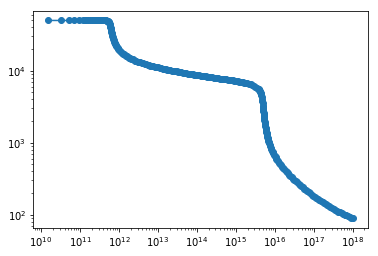

In [123]:
flag = rv_int['successful']
# plt.loglog(rv_int['t'][flag],rv_int['H2_1'][0][flag],'-o')
# plt.loglog(rv_int['t'][flag],rv_int['H_1'][0][flag],'-o')
plt.loglog(rv_int['t'][flag],rv_int['T'][0][flag],'-o')
rv_int['T'][0][flag][-1]

H_2
H_1
He_1
He_2
He_3
H2_2
H2_1
H_m0
T


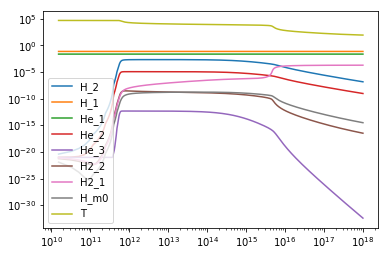

In [124]:
flag = rv_int['successful']

t = rv_int['t'][flag]
for key in rv_int.keys():
    if key not in ['ge','de','successful','t','dt']:
        print(key)
        vals = rv_int[key][0][flag]
        plt.loglog(t, vals,label=key)
plt.legend()
plt.show()

In [125]:
total_t = 0.0
final_density = 1.0e14*1.007947
density_array = numpy.array([ init['density'] ])
pressure_array = numpy.array([])
ttt = []
run_time = []
current_density = density_array[-1]

all_data = {}
for key in init.keys():
    all_data[key] = []
all_data['force_factor'] = []

In [126]:
dir_ff_grackle = "/home/kwoksun2/grackle/src/python/examples/freefall.h5"
import h5py
f = h5py.File(dir_ff_grackle)
fdata = f['data']
grackle_init = convert_from_grackle_to_dengo(fdata)


init, primordial = Init_values( temperature , density , n_species = 9, size=1)
for i in new_init.keys():
    if i not in ['density','ge']:
        print(i, grackle_init[i]) 
        init[i] = numpy.array([grackle_init[i]])

init['de'] = primordial.calculate_free_electrons(init)
init['ge'] =  calculate_energy(init, primordial)
rv, rv_int = bechem_cvdls_run.run_test_bechem_cvdls(init, 1e-5,niter=1e0)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [127]:
iterrr = 0
while current_density < final_density:

    # keep track of time in here
    
    new_init = generate_init_from_results(rv_int, primordial, init)
    init, pressure_array, density_array, dt, force_factor = update_initial_condition(new_init, primordial, pressure_array
                                                             , density_array, safety_factor=0.01)
    
    tic = time.time()
    rv, rv_int = bechem_cvdls_run.run_test_bechem_cvdls(init, dt)
    toc = time.time()
    total_t += dt
    ttt.append(float(total_t))
    run_time.append(toc-tic)
    
    flag = rv_int['successful']
    for key in init.keys():
        if key not in ['density']:
            data = rv_int[key][0][flag][-1]
            all_data[key].append(data)
    all_data['force_factor'].append( float(force_factor))
    current_density = density_array[-1]
    
    
    t_ends = rv_int['t'][flag][-1]
    if t_ends < dt:
        print('##########cannot finish the run....####################3')
        break
#     iterrr += 1
#     if iterrr > 0:
#         break

force_factor: 0.0
gammma - 1: 0.666084061759
Successful iteration[    0]: (1.451e+09) 1.451e+09 / 1.451e+13
End in 73 iterations: 1.45083e+13 / 1.45083e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666084698332
Successful iteration[    0]: (1.444e+09) 1.444e+09 / 1.444e+13
End in 73 iterations: 1.44358e+13 / 1.44358e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666085347306
Successful iteration[    0]: (1.436e+09) 1.436e+09 / 1.436e+13
End in 73 iterations: 1.43636e+13 / 1.43636e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666086008433
Successful iteration[    0]: (1.429e+09) 1.429e+09 / 1.429e+13
End in 73 iterations: 1.42918e+13 / 1.42918e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666086681471
Successful iteration[    0]: (1.422e+09) 1.422e+09 / 1.422e+13
End in 73 iterations: 1.42203e+13 / 1.42203e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666087366175
Successful iteration[    0]: (1.415e+09) 1.415e+09 / 1.415e+13
End in 73 iterations: 1.41492e+13 / 1.4149

gammma - 1: 0.666124201429
Successful iteration[    0]: (1.141e+09) 1.141e+09 / 1.141e+13
End in 73 iterations: 1.14058e+13 / 1.14058e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666125143775
Successful iteration[    0]: (1.135e+09) 1.135e+09 / 1.135e+13
End in 73 iterations: 1.13487e+13 / 1.13487e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666126086143
Successful iteration[    0]: (1.129e+09) 1.129e+09 / 1.129e+13
End in 73 iterations: 1.12920e+13 / 1.12920e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666127028285
Successful iteration[    0]: (1.124e+09) 1.124e+09 / 1.124e+13
End in 73 iterations: 1.12355e+13 / 1.12355e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666127969957
Successful iteration[    0]: (1.118e+09) 1.118e+09 / 1.118e+13
End in 73 iterations: 1.11794e+13 / 1.11794e+13 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666128910911
Successful iteration[    0]: (1.112e+09) 1.112e+09 / 1.112e+13
End in 73 iterations: 1.11235e+13 / 1.11235e+13 (0.00000e+00

Successful iteration[    0]: (8.967e+08) 8.967e+08 / 8.967e+12
End in 73 iterations: 8.96670e+12 / 8.96670e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666166276194
Successful iteration[    0]: (8.922e+08) 8.922e+08 / 8.922e+12
End in 73 iterations: 8.92187e+12 / 8.92187e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666166968806
Successful iteration[    0]: (8.877e+08) 8.877e+08 / 8.877e+12
End in 73 iterations: 8.87726e+12 / 8.87726e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66616765213
Successful iteration[    0]: (8.833e+08) 8.833e+08 / 8.833e+12
End in 73 iterations: 8.83287e+12 / 8.83287e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666168326059
Successful iteration[    0]: (8.789e+08) 8.789e+08 / 8.789e+12
End in 73 iterations: 8.78871e+12 / 8.78871e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666168990482
Successful iteration[    0]: (8.745e+08) 8.745e+08 / 8.745e+12
End in 73 iterations: 8.74476e+12 / 8.74476e+12 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (7.049e+08) 7.049e+08 / 7.049e+12
End in 73 iterations: 7.04921e+12 / 7.04921e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666187875623
Successful iteration[    0]: (7.014e+08) 7.014e+08 / 7.014e+12
End in 73 iterations: 7.01396e+12 / 7.01396e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666188064058
Successful iteration[    0]: (6.979e+08) 6.979e+08 / 6.979e+12
End in 73 iterations: 6.97890e+12 / 6.97890e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666188242235
Successful iteration[    0]: (6.944e+08) 6.944e+08 / 6.944e+12
End in 73 iterations: 6.94400e+12 / 6.94400e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666188410224
Successful iteration[    0]: (6.909e+08) 6.909e+08 / 6.909e+12
End in 73 iterations: 6.90928e+12 / 6.90928e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.6661885681
Successful iteration[    0]: (6.875e+08) 6.875e+08 / 6.875e+12
End in 73 iterations: 6.87473e+12 / 6.87473e+12 (0.00000e+00)
force_factor: 0.0
gammma - 

Successful iteration[    0]: (5.542e+08) 5.542e+08 / 5.542e+12
End in 73 iterations: 5.54177e+12 / 5.54177e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666187131184
Successful iteration[    0]: (5.514e+08) 5.514e+08 / 5.514e+12
End in 73 iterations: 5.51406e+12 / 5.51406e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186953524
Successful iteration[    0]: (5.486e+08) 5.486e+08 / 5.486e+12
End in 73 iterations: 5.48649e+12 / 5.48649e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186771685
Successful iteration[    0]: (5.459e+08) 5.459e+08 / 5.459e+12
End in 73 iterations: 5.45906e+12 / 5.45906e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186585823
Successful iteration[    0]: (5.432e+08) 5.432e+08 / 5.432e+12
End in 73 iterations: 5.43176e+12 / 5.43176e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66618639609
Successful iteration[    0]: (5.405e+08) 5.405e+08 / 5.405e+12
End in 73 iterations: 5.40460e+12 / 5.40460e+12 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (4.357e+08) 4.357e+08 / 4.357e+12
End in 73 iterations: 4.35669e+12 / 4.35669e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666176357105
Successful iteration[    0]: (4.335e+08) 4.335e+08 / 4.335e+12
End in 73 iterations: 4.33490e+12 / 4.33490e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666176132228
Successful iteration[    0]: (4.313e+08) 4.313e+08 / 4.313e+12
End in 73 iterations: 4.31323e+12 / 4.31323e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666175908947
Successful iteration[    0]: (4.292e+08) 4.292e+08 / 4.292e+12
End in 73 iterations: 4.29166e+12 / 4.29166e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666175687347
Successful iteration[    0]: (4.270e+08) 4.270e+08 / 4.270e+12
End in 73 iterations: 4.27020e+12 / 4.27020e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666175467466
Successful iteration[    0]: (4.249e+08) 4.249e+08 / 4.249e+12
End in 73 iterations: 4.24885e+12 / 4.24885e+12 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (3.425e+08) 3.425e+08 / 3.425e+12
End in 73 iterations: 3.42503e+12 / 3.42503e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666168053997
Successful iteration[    0]: (3.408e+08) 3.408e+08 / 3.408e+12
End in 73 iterations: 3.40790e+12 / 3.40790e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666167941256
Successful iteration[    0]: (3.391e+08) 3.391e+08 / 3.391e+12
End in 73 iterations: 3.39086e+12 / 3.39086e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666167830921
Successful iteration[    0]: (3.374e+08) 3.374e+08 / 3.374e+12
End in 73 iterations: 3.37391e+12 / 3.37391e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666167722955
Successful iteration[    0]: (3.357e+08) 3.357e+08 / 3.357e+12
End in 73 iterations: 3.35704e+12 / 3.35704e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666167617332
Successful iteration[    0]: (3.340e+08) 3.340e+08 / 3.340e+12
End in 73 iterations: 3.34025e+12 / 3.34025e+12 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (2.693e+08) 2.693e+08 / 2.693e+12
End in 73 iterations: 2.69260e+12 / 2.69260e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666164969293
Successful iteration[    0]: (2.679e+08) 2.679e+08 / 2.679e+12
End in 73 iterations: 2.67914e+12 / 2.67914e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66616494671
Successful iteration[    0]: (2.666e+08) 2.666e+08 / 2.666e+12
End in 73 iterations: 2.66574e+12 / 2.66574e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666164925473
Successful iteration[    0]: (2.652e+08) 2.652e+08 / 2.652e+12
End in 73 iterations: 2.65241e+12 / 2.65241e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66616490556
Successful iteration[    0]: (2.639e+08) 2.639e+08 / 2.639e+12
End in 73 iterations: 2.63915e+12 / 2.63915e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666164886953
Successful iteration[    0]: (2.626e+08) 2.626e+08 / 2.626e+12
End in 73 iterations: 2.62596e+12 / 2.62596e+12 (0.00000e+00)
force_factor: 0.0
gammma - 

Successful iteration[    0]: (2.117e+08) 2.117e+08 / 2.117e+12
End in 73 iterations: 2.11680e+12 / 2.11680e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666165120707
Successful iteration[    0]: (2.106e+08) 2.106e+08 / 2.106e+12
End in 73 iterations: 2.10622e+12 / 2.10622e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666165145501
Successful iteration[    0]: (2.096e+08) 2.096e+08 / 2.096e+12
End in 73 iterations: 2.09569e+12 / 2.09569e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666165170995
Successful iteration[    0]: (2.085e+08) 2.085e+08 / 2.085e+12
End in 73 iterations: 2.08521e+12 / 2.08521e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666165197183
Successful iteration[    0]: (2.075e+08) 2.075e+08 / 2.075e+12
End in 73 iterations: 2.07478e+12 / 2.07478e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666165224058
Successful iteration[    0]: (2.064e+08) 2.064e+08 / 2.064e+12
End in 73 iterations: 2.06441e+12 / 2.06441e+12 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.664e+08) 1.664e+08 / 1.664e+12
End in 73 iterations: 1.66413e+12 / 1.66413e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666166993149
Successful iteration[    0]: (1.656e+08) 1.656e+08 / 1.656e+12
End in 73 iterations: 1.65581e+12 / 1.65581e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666167044905
Successful iteration[    0]: (1.648e+08) 1.648e+08 / 1.648e+12
End in 73 iterations: 1.64753e+12 / 1.64753e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666167097108
Successful iteration[    0]: (1.639e+08) 1.639e+08 / 1.639e+12
End in 73 iterations: 1.63929e+12 / 1.63929e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666167149756
Successful iteration[    0]: (1.631e+08) 1.631e+08 / 1.631e+12
End in 73 iterations: 1.63110e+12 / 1.63110e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666167202849
Successful iteration[    0]: (1.623e+08) 1.623e+08 / 1.623e+12
End in 73 iterations: 1.62294e+12 / 1.62294e+12 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.308e+08) 1.308e+08 / 1.308e+12
End in 73 iterations: 1.30826e+12 / 1.30826e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666169932521
Successful iteration[    0]: (1.302e+08) 1.302e+08 / 1.302e+12
End in 73 iterations: 1.30172e+12 / 1.30172e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666170002534
Successful iteration[    0]: (1.295e+08) 1.295e+08 / 1.295e+12
End in 73 iterations: 1.29521e+12 / 1.29521e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666170072854
Successful iteration[    0]: (1.289e+08) 1.289e+08 / 1.289e+12
End in 73 iterations: 1.28874e+12 / 1.28874e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666170143484
Successful iteration[    0]: (1.282e+08) 1.282e+08 / 1.282e+12
End in 73 iterations: 1.28230e+12 / 1.28230e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666170214426
Successful iteration[    0]: (1.276e+08) 1.276e+08 / 1.276e+12
End in 73 iterations: 1.27588e+12 / 1.27588e+12 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.028e+08) 1.028e+08 / 1.028e+12
End in 73 iterations: 1.02850e+12 / 1.02850e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173594489
Successful iteration[    0]: (1.023e+08) 1.023e+08 / 1.023e+12
End in 73 iterations: 1.02336e+12 / 1.02336e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173676054
Successful iteration[    0]: (1.018e+08) 1.018e+08 / 1.018e+12
End in 73 iterations: 1.01824e+12 / 1.01824e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173757764
Successful iteration[    0]: (1.013e+08) 1.013e+08 / 1.013e+12
End in 73 iterations: 1.01315e+12 / 1.01315e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173839621
Successful iteration[    0]: (1.008e+08) 1.008e+08 / 1.008e+12
End in 73 iterations: 1.00808e+12 / 1.00808e+12 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173921625
Successful iteration[    0]: (1.003e+08) 1.003e+08 / 1.003e+12
End in 73 iterations: 1.00304e+12 / 1.00304e+12 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (8.086e+07) 8.086e+07 / 8.086e+11
End in 73 iterations: 8.08558e+11 / 8.08558e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666177608105
Successful iteration[    0]: (8.045e+07) 8.045e+07 / 8.045e+11
End in 73 iterations: 8.04516e+11 / 8.04516e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666177691997
Successful iteration[    0]: (8.005e+07) 8.005e+07 / 8.005e+11
End in 73 iterations: 8.00493e+11 / 8.00493e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666177775814
Successful iteration[    0]: (7.965e+07) 7.965e+07 / 7.965e+11
End in 73 iterations: 7.96491e+11 / 7.96491e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666177859556
Successful iteration[    0]: (7.925e+07) 7.925e+07 / 7.925e+11
End in 73 iterations: 7.92508e+11 / 7.92508e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66617794322
Successful iteration[    0]: (7.885e+07) 7.885e+07 / 7.885e+11
End in 73 iterations: 7.88546e+11 / 7.88546e+11 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (6.357e+07) 6.357e+07 / 6.357e+11
End in 73 iterations: 6.35652e+11 / 6.35652e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666181453314
Successful iteration[    0]: (6.325e+07) 6.325e+07 / 6.325e+11
End in 73 iterations: 6.32474e+11 / 6.32474e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666181527204
Successful iteration[    0]: (6.293e+07) 6.293e+07 / 6.293e+11
End in 73 iterations: 6.29311e+11 / 6.29311e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666181600741
Successful iteration[    0]: (6.262e+07) 6.262e+07 / 6.262e+11
End in 73 iterations: 6.26165e+11 / 6.26165e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666181673913
Successful iteration[    0]: (6.230e+07) 6.230e+07 / 6.230e+11
End in 73 iterations: 6.23034e+11 / 6.23034e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66618174672
Successful iteration[    0]: (6.199e+07) 6.199e+07 / 6.199e+11
End in 73 iterations: 6.19919e+11 / 6.19919e+11 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (4.997e+07) 4.997e+07 / 4.997e+11
End in 73 iterations: 4.99720e+11 / 4.99720e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666184506812
Successful iteration[    0]: (4.972e+07) 4.972e+07 / 4.972e+11
End in 73 iterations: 4.97222e+11 / 4.97222e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666184557667
Successful iteration[    0]: (4.947e+07) 4.947e+07 / 4.947e+11
End in 73 iterations: 4.94736e+11 / 4.94736e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666184607923
Successful iteration[    0]: (4.923e+07) 4.923e+07 / 4.923e+11
End in 73 iterations: 4.92262e+11 / 4.92262e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666184657578
Successful iteration[    0]: (4.898e+07) 4.898e+07 / 4.898e+11
End in 73 iterations: 4.89801e+11 / 4.89801e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666184706629
Successful iteration[    0]: (4.874e+07) 4.874e+07 / 4.874e+11
End in 73 iterations: 4.87352e+11 / 4.87352e+11 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (3.929e+07) 3.929e+07 / 3.929e+11
End in 73 iterations: 3.92857e+11 / 3.92857e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186210098
Successful iteration[    0]: (3.909e+07) 3.909e+07 / 3.909e+11
End in 73 iterations: 3.90893e+11 / 3.90893e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186228476
Successful iteration[    0]: (3.889e+07) 3.889e+07 / 3.889e+11
End in 73 iterations: 3.88939e+11 / 3.88939e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186246128
Successful iteration[    0]: (3.870e+07) 3.870e+07 / 3.870e+11
End in 73 iterations: 3.86994e+11 / 3.86994e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186263049
Successful iteration[    0]: (3.851e+07) 3.851e+07 / 3.851e+11
End in 73 iterations: 3.85059e+11 / 3.85059e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186279236
Successful iteration[    0]: (3.831e+07) 3.831e+07 / 3.831e+11
End in 73 iterations: 3.83134e+11 / 3.83134e+11 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (3.088e+07) 3.088e+07 / 3.088e+11
End in 73 iterations: 3.08847e+11 / 3.08847e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186268874
Successful iteration[    0]: (3.073e+07) 3.073e+07 / 3.073e+11
End in 73 iterations: 3.07302e+11 / 3.07302e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186252582
Successful iteration[    0]: (3.058e+07) 3.058e+07 / 3.058e+11
End in 73 iterations: 3.05766e+11 / 3.05766e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186235607
Successful iteration[    0]: (3.042e+07) 3.042e+07 / 3.042e+11
End in 73 iterations: 3.04237e+11 / 3.04237e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186217953
Successful iteration[    0]: (3.027e+07) 3.027e+07 / 3.027e+11
End in 73 iterations: 3.02716e+11 / 3.02716e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666186199621
Successful iteration[    0]: (3.012e+07) 3.012e+07 / 3.012e+11
End in 73 iterations: 3.01202e+11 / 3.01202e+11 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (2.428e+07) 2.428e+07 / 2.428e+11
End in 73 iterations: 2.42801e+11 / 2.42801e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666184782538
Successful iteration[    0]: (2.416e+07) 2.416e+07 / 2.416e+11
End in 73 iterations: 2.41587e+11 / 2.41587e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66618473809
Successful iteration[    0]: (2.404e+07) 2.404e+07 / 2.404e+11
End in 73 iterations: 2.40379e+11 / 2.40379e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666184693184
Successful iteration[    0]: (2.392e+07) 2.392e+07 / 2.392e+11
End in 73 iterations: 2.39177e+11 / 2.39177e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666184647825
Successful iteration[    0]: (2.380e+07) 2.380e+07 / 2.380e+11
End in 73 iterations: 2.37981e+11 / 2.37981e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666184602016
Successful iteration[    0]: (2.368e+07) 2.368e+07 / 2.368e+11
End in 73 iterations: 2.36792e+11 / 2.36792e+11 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (1.909e+07) 1.909e+07 / 1.909e+11
End in 73 iterations: 1.90879e+11 / 1.90879e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666182243913
Successful iteration[    0]: (1.899e+07) 1.899e+07 / 1.899e+11
End in 73 iterations: 1.89925e+11 / 1.89925e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666182184936
Successful iteration[    0]: (1.890e+07) 1.890e+07 / 1.890e+11
End in 73 iterations: 1.88975e+11 / 1.88975e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666182125829
Successful iteration[    0]: (1.880e+07) 1.880e+07 / 1.880e+11
End in 73 iterations: 1.88030e+11 / 1.88030e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666182066604
Successful iteration[    0]: (1.871e+07) 1.871e+07 / 1.871e+11
End in 73 iterations: 1.87090e+11 / 1.87090e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66618200727
Successful iteration[    0]: (1.862e+07) 1.862e+07 / 1.862e+11
End in 73 iterations: 1.86155e+11 / 1.86155e+11 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (1.501e+07) 1.501e+07 / 1.501e+11
End in 73 iterations: 1.50061e+11 / 1.50061e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666179389484
Successful iteration[    0]: (1.493e+07) 1.493e+07 / 1.493e+11
End in 73 iterations: 1.49310e+11 / 1.49310e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666179332104
Successful iteration[    0]: (1.486e+07) 1.486e+07 / 1.486e+11
End in 73 iterations: 1.48564e+11 / 1.48564e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666179274915
Successful iteration[    0]: (1.478e+07) 1.478e+07 / 1.478e+11
End in 73 iterations: 1.47821e+11 / 1.47821e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666179217927
Successful iteration[    0]: (1.471e+07) 1.471e+07 / 1.471e+11
End in 73 iterations: 1.47082e+11 / 1.47082e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666179161142
Successful iteration[    0]: (1.463e+07) 1.463e+07 / 1.463e+11
End in 73 iterations: 1.46346e+11 / 1.46346e+11 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.180e+07) 1.180e+07 / 1.180e+11
End in 73 iterations: 1.17971e+11 / 1.17971e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666176929989
Successful iteration[    0]: (1.174e+07) 1.174e+07 / 1.174e+11
End in 73 iterations: 1.17381e+11 / 1.17381e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666176886653
Successful iteration[    0]: (1.168e+07) 1.168e+07 / 1.168e+11
End in 73 iterations: 1.16794e+11 / 1.16794e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666176843687
Successful iteration[    0]: (1.162e+07) 1.162e+07 / 1.162e+11
End in 73 iterations: 1.16210e+11 / 1.16210e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666176801092
Successful iteration[    0]: (1.156e+07) 1.156e+07 / 1.156e+11
End in 73 iterations: 1.15629e+11 / 1.15629e+11 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666176758871
Successful iteration[    0]: (1.151e+07) 1.151e+07 / 1.151e+11
End in 73 iterations: 1.15051e+11 / 1.15051e+11 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (9.274e+06) 9.274e+06 / 9.274e+10
End in 73 iterations: 9.27432e+10 / 9.27432e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666175280898
Successful iteration[    0]: (9.228e+06) 9.228e+06 / 9.228e+10
End in 73 iterations: 9.22795e+10 / 9.22795e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666175255889
Successful iteration[    0]: (9.182e+06) 9.182e+06 / 9.182e+10
End in 73 iterations: 9.18181e+10 / 9.18181e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666175231246
Successful iteration[    0]: (9.136e+06) 9.136e+06 / 9.136e+10
End in 73 iterations: 9.13590e+10 / 9.13590e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666175206965
Successful iteration[    0]: (9.090e+06) 9.090e+06 / 9.090e+10
End in 73 iterations: 9.09022e+10 / 9.09022e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666175183046
Successful iteration[    0]: (9.045e+06) 9.045e+06 / 9.045e+10
End in 73 iterations: 9.04477e+10 / 9.04477e+10 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (7.291e+06) 7.291e+06 / 7.291e+10
End in 73 iterations: 7.29105e+10 / 7.29105e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666174447832
Successful iteration[    0]: (7.255e+06) 7.255e+06 / 7.255e+10
End in 73 iterations: 7.25460e+10 / 7.25460e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666174437168
Successful iteration[    0]: (7.218e+06) 7.218e+06 / 7.218e+10
End in 73 iterations: 7.21832e+10 / 7.21832e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666174426718
Successful iteration[    0]: (7.182e+06) 7.182e+06 / 7.182e+10
End in 73 iterations: 7.18223e+10 / 7.18223e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666174416479
Successful iteration[    0]: (7.146e+06) 7.146e+06 / 7.146e+10
End in 73 iterations: 7.14632e+10 / 7.14632e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666174406445
Successful iteration[    0]: (7.111e+06) 7.111e+06 / 7.111e+10
End in 73 iterations: 7.11059e+10 / 7.11059e+10 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (5.732e+06) 5.732e+06 / 5.732e+10
End in 73 iterations: 5.73189e+10 / 5.73189e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666174093363
Successful iteration[    0]: (5.703e+06) 5.703e+06 / 5.703e+10
End in 73 iterations: 5.70323e+10 / 5.70323e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666174087468
Successful iteration[    0]: (5.675e+06) 5.675e+06 / 5.675e+10
End in 73 iterations: 5.67472e+10 / 5.67472e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666174081541
Successful iteration[    0]: (5.646e+06) 5.646e+06 / 5.646e+10
End in 73 iterations: 5.64634e+10 / 5.64634e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66617407558
Successful iteration[    0]: (5.618e+06) 5.618e+06 / 5.618e+10
End in 73 iterations: 5.61811e+10 / 5.61811e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666174069581
Successful iteration[    0]: (5.590e+06) 5.590e+06 / 5.590e+10
End in 73 iterations: 5.59002e+10 / 5.59002e+10 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (4.506e+06) 4.506e+06 / 4.506e+10
End in 73 iterations: 4.50615e+10 / 4.50615e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173691794
Successful iteration[    0]: (4.484e+06) 4.484e+06 / 4.484e+10
End in 73 iterations: 4.48362e+10 / 4.48362e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173678808
Successful iteration[    0]: (4.461e+06) 4.461e+06 / 4.461e+10
End in 73 iterations: 4.46120e+10 / 4.46120e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173665543
Successful iteration[    0]: (4.439e+06) 4.439e+06 / 4.439e+10
End in 73 iterations: 4.43890e+10 / 4.43890e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173651993
Successful iteration[    0]: (4.417e+06) 4.417e+06 / 4.417e+10
End in 73 iterations: 4.41670e+10 / 4.41670e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666173638149
Successful iteration[    0]: (4.395e+06) 4.395e+06 / 4.395e+10
End in 73 iterations: 4.39462e+10 / 4.39462e+10 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (3.543e+06) 3.543e+06 / 3.543e+10
End in 73 iterations: 3.54253e+10 / 3.54253e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666172672807
Successful iteration[    0]: (3.525e+06) 3.525e+06 / 3.525e+10
End in 73 iterations: 3.52482e+10 / 3.52482e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666172641171
Successful iteration[    0]: (3.507e+06) 3.507e+06 / 3.507e+10
End in 73 iterations: 3.50720e+10 / 3.50720e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666172609039
Successful iteration[    0]: (3.490e+06) 3.490e+06 / 3.490e+10
End in 73 iterations: 3.48966e+10 / 3.48966e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666172576404
Successful iteration[    0]: (3.472e+06) 3.472e+06 / 3.472e+10
End in 73 iterations: 3.47221e+10 / 3.47221e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66617254326
Successful iteration[    0]: (3.455e+06) 3.455e+06 / 3.455e+10
End in 73 iterations: 3.45485e+10 / 3.45485e+10 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (2.785e+06) 2.785e+06 / 2.785e+10
End in 73 iterations: 2.78498e+10 / 2.78498e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666170526629
Successful iteration[    0]: (2.771e+06) 2.771e+06 / 2.771e+10
End in 73 iterations: 2.77105e+10 / 2.77105e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666170466946
Successful iteration[    0]: (2.757e+06) 2.757e+06 / 2.757e+10
End in 73 iterations: 2.75720e+10 / 2.75720e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666170406602
Successful iteration[    0]: (2.743e+06) 2.743e+06 / 2.743e+10
End in 73 iterations: 2.74341e+10 / 2.74341e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666170345594
Successful iteration[    0]: (2.730e+06) 2.730e+06 / 2.730e+10
End in 73 iterations: 2.72969e+10 / 2.72969e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66617028392
Successful iteration[    0]: (2.716e+06) 2.716e+06 / 2.716e+10
End in 73 iterations: 2.71605e+10 / 2.71605e+10 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (2.189e+06) 2.189e+06 / 2.189e+10
End in 73 iterations: 2.18942e+10 / 2.18942e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666166877805
Successful iteration[    0]: (2.178e+06) 2.178e+06 / 2.178e+10
End in 73 iterations: 2.17848e+10 / 2.17848e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666166784061
Successful iteration[    0]: (2.168e+06) 2.168e+06 / 2.168e+10
End in 73 iterations: 2.16758e+10 / 2.16758e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666166689571
Successful iteration[    0]: (2.157e+06) 2.157e+06 / 2.157e+10
End in 73 iterations: 2.15674e+10 / 2.15674e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666166594334
Successful iteration[    0]: (2.146e+06) 2.146e+06 / 2.146e+10
End in 73 iterations: 2.14596e+10 / 2.14596e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666166498346
Successful iteration[    0]: (2.135e+06) 2.135e+06 / 2.135e+10
End in 73 iterations: 2.13523e+10 / 2.13523e+10 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.721e+06) 1.721e+06 / 1.721e+10
End in 73 iterations: 1.72122e+10 / 1.72122e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666161527746
Successful iteration[    0]: (1.713e+06) 1.713e+06 / 1.713e+10
End in 73 iterations: 1.71262e+10 / 1.71262e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666161397768
Successful iteration[    0]: (1.704e+06) 1.704e+06 / 1.704e+10
End in 73 iterations: 1.70405e+10 / 1.70405e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666161267033
Successful iteration[    0]: (1.696e+06) 1.696e+06 / 1.696e+10
End in 73 iterations: 1.69553e+10 / 1.69553e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666161135547
Successful iteration[    0]: (1.687e+06) 1.687e+06 / 1.687e+10
End in 73 iterations: 1.68706e+10 / 1.68706e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666161003314
Successful iteration[    0]: (1.679e+06) 1.679e+06 / 1.679e+10
End in 73 iterations: 1.67862e+10 / 1.67862e+10 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.353e+06) 1.353e+06 / 1.353e+10
End in 73 iterations: 1.35315e+10 / 1.35315e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666154456363
Successful iteration[    0]: (1.346e+06) 1.346e+06 / 1.346e+10
End in 73 iterations: 1.34638e+10 / 1.34638e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666154291409
Successful iteration[    0]: (1.340e+06) 1.340e+06 / 1.340e+10
End in 73 iterations: 1.33965e+10 / 1.33965e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666154125764
Successful iteration[    0]: (1.333e+06) 1.333e+06 / 1.333e+10
End in 73 iterations: 1.33295e+10 / 1.33295e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666153959423
Successful iteration[    0]: (1.326e+06) 1.326e+06 / 1.326e+10
End in 73 iterations: 1.32629e+10 / 1.32629e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66615379238
Successful iteration[    0]: (1.320e+06) 1.320e+06 / 1.320e+10
End in 73 iterations: 1.31966e+10 / 1.31966e+10 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (1.064e+06) 1.064e+06 / 1.064e+10
End in 73 iterations: 1.06378e+10 / 1.06378e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666145779978
Successful iteration[    0]: (1.058e+06) 1.058e+06 / 1.058e+10
End in 73 iterations: 1.05846e+10 / 1.05846e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66614558341
Successful iteration[    0]: (1.053e+06) 1.053e+06 / 1.053e+10
End in 73 iterations: 1.05317e+10 / 1.05317e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666145386216
Successful iteration[    0]: (1.048e+06) 1.048e+06 / 1.048e+10
End in 73 iterations: 1.04791e+10 / 1.04791e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66614518841
Successful iteration[    0]: (1.043e+06) 1.043e+06 / 1.043e+10
End in 73 iterations: 1.04267e+10 / 1.04267e+10 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666144990004
Successful iteration[    0]: (1.037e+06) 1.037e+06 / 1.037e+10
End in 73 iterations: 1.03745e+10 / 1.03745e+10 (0.00000e+00)
force_factor: 0.0
gammma - 

Successful iteration[    0]: (8.363e+05) 8.363e+05 / 8.363e+09
End in 73 iterations: 8.36298e+09 / 8.36298e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666135679873
Successful iteration[    0]: (8.321e+05) 8.321e+05 / 8.321e+09
End in 73 iterations: 8.32116e+09 / 8.32116e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666135455639
Successful iteration[    0]: (8.280e+05) 8.280e+05 / 8.280e+09
End in 73 iterations: 8.27956e+09 / 8.27956e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666135230886
Successful iteration[    0]: (8.238e+05) 8.238e+05 / 8.238e+09
End in 73 iterations: 8.23816e+09 / 8.23816e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666135005606
Successful iteration[    0]: (8.197e+05) 8.197e+05 / 8.197e+09
End in 73 iterations: 8.19697e+09 / 8.19697e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666134779788
Successful iteration[    0]: (8.156e+05) 8.156e+05 / 8.156e+09
End in 73 iterations: 8.15599e+09 / 8.15599e+09 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (6.575e+05) 6.575e+05 / 6.575e+09
End in 73 iterations: 6.57459e+09 / 6.57459e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666124332292
Successful iteration[    0]: (6.542e+05) 6.542e+05 / 6.542e+09
End in 73 iterations: 6.54172e+09 / 6.54172e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666124083646
Successful iteration[    0]: (6.509e+05) 6.509e+05 / 6.509e+09
End in 73 iterations: 6.50901e+09 / 6.50901e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666123834522
Successful iteration[    0]: (6.476e+05) 6.476e+05 / 6.476e+09
End in 73 iterations: 6.47647e+09 / 6.47647e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666123584911
Successful iteration[    0]: (6.444e+05) 6.444e+05 / 6.444e+09
End in 73 iterations: 6.44408e+09 / 6.44408e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666123334801
Successful iteration[    0]: (6.412e+05) 6.412e+05 / 6.412e+09
End in 73 iterations: 6.41186e+09 / 6.41186e+09 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (5.169e+05) 5.169e+05 / 5.169e+09
End in 73 iterations: 5.16865e+09 / 5.16865e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666111862172
Successful iteration[    0]: (5.143e+05) 5.143e+05 / 5.143e+09
End in 73 iterations: 5.14280e+09 / 5.14280e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666111590982
Successful iteration[    0]: (5.117e+05) 5.117e+05 / 5.117e+09
End in 73 iterations: 5.11709e+09 / 5.11709e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666111319347
Successful iteration[    0]: (5.092e+05) 5.092e+05 / 5.092e+09
End in 73 iterations: 5.09150e+09 / 5.09150e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666111047256
Successful iteration[    0]: (5.066e+05) 5.066e+05 / 5.066e+09
End in 73 iterations: 5.06605e+09 / 5.06605e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666110774696
Successful iteration[    0]: (5.041e+05) 5.041e+05 / 5.041e+09
End in 73 iterations: 5.04072e+09 / 5.04072e+09 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (4.063e+05) 4.063e+05 / 4.063e+09
End in 73 iterations: 4.06335e+09 / 4.06335e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666098327969
Successful iteration[    0]: (4.043e+05) 4.043e+05 / 4.043e+09
End in 73 iterations: 4.04304e+09 / 4.04304e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666098034741
Successful iteration[    0]: (4.023e+05) 4.023e+05 / 4.023e+09
End in 73 iterations: 4.02282e+09 / 4.02282e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666097741053
Successful iteration[    0]: (4.003e+05) 4.003e+05 / 4.003e+09
End in 73 iterations: 4.00271e+09 / 4.00271e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666097446915
Successful iteration[    0]: (3.983e+05) 3.983e+05 / 3.983e+09
End in 73 iterations: 3.98269e+09 / 3.98269e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666097152336
Successful iteration[    0]: (3.963e+05) 3.963e+05 / 3.963e+09
End in 73 iterations: 3.96278e+09 / 3.96278e+09 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (3.194e+05) 3.194e+05 / 3.194e+09
End in 73 iterations: 3.19442e+09 / 3.19442e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666083727137
Successful iteration[    0]: (3.178e+05) 3.178e+05 / 3.178e+09
End in 73 iterations: 3.17845e+09 / 3.17845e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666083411347
Successful iteration[    0]: (3.163e+05) 3.163e+05 / 3.163e+09
End in 73 iterations: 3.16256e+09 / 3.16256e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666083095078
Successful iteration[    0]: (3.147e+05) 3.147e+05 / 3.147e+09
End in 73 iterations: 3.14675e+09 / 3.14675e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666082778318
Successful iteration[    0]: (3.131e+05) 3.131e+05 / 3.131e+09
End in 73 iterations: 3.13101e+09 / 3.13101e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666082461059
Successful iteration[    0]: (3.115e+05) 3.115e+05 / 3.115e+09
End in 73 iterations: 3.11536e+09 / 3.11536e+09 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (2.511e+05) 2.511e+05 / 2.511e+09
End in 73 iterations: 2.51131e+09 / 2.51131e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666068010532
Successful iteration[    0]: (2.499e+05) 2.499e+05 / 2.499e+09
End in 73 iterations: 2.49875e+09 / 2.49875e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666067670705
Successful iteration[    0]: (2.486e+05) 2.486e+05 / 2.486e+09
End in 73 iterations: 2.48626e+09 / 2.48626e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666067330345
Successful iteration[    0]: (2.474e+05) 2.474e+05 / 2.474e+09
End in 73 iterations: 2.47383e+09 / 2.47383e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666066989446
Successful iteration[    0]: (2.461e+05) 2.461e+05 / 2.461e+09
End in 73 iterations: 2.46146e+09 / 2.46146e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666066648016
Successful iteration[    0]: (2.449e+05) 2.449e+05 / 2.449e+09
End in 73 iterations: 2.44915e+09 / 2.44915e+09 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.974e+05) 1.974e+05 / 1.974e+09
End in 73 iterations: 1.97428e+09 / 1.97428e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666051094455
Successful iteration[    0]: (1.964e+05) 1.964e+05 / 1.964e+09
End in 73 iterations: 1.96441e+09 / 1.96441e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666050728551
Successful iteration[    0]: (1.955e+05) 1.955e+05 / 1.955e+09
End in 73 iterations: 1.95458e+09 / 1.95458e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666050362064
Successful iteration[    0]: (1.945e+05) 1.945e+05 / 1.945e+09
End in 73 iterations: 1.94481e+09 / 1.94481e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666049994993
Successful iteration[    0]: (1.935e+05) 1.935e+05 / 1.935e+09
End in 73 iterations: 1.93509e+09 / 1.93509e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666049627345
Successful iteration[    0]: (1.925e+05) 1.925e+05 / 1.925e+09
End in 73 iterations: 1.92541e+09 / 1.92541e+09 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.552e+05) 1.552e+05 / 1.552e+09
End in 73 iterations: 1.55209e+09 / 1.55209e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666032868768
Successful iteration[    0]: (1.544e+05) 1.544e+05 / 1.544e+09
End in 73 iterations: 1.54433e+09 / 1.54433e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666032474239
Successful iteration[    0]: (1.537e+05) 1.537e+05 / 1.537e+09
End in 73 iterations: 1.53661e+09 / 1.53661e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666032079077
Successful iteration[    0]: (1.529e+05) 1.529e+05 / 1.529e+09
End in 73 iterations: 1.52892e+09 / 1.52892e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666031683277
Successful iteration[    0]: (1.521e+05) 1.521e+05 / 1.521e+09
End in 73 iterations: 1.52128e+09 / 1.52128e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666031286833
Successful iteration[    0]: (1.514e+05) 1.514e+05 / 1.514e+09
End in 73 iterations: 1.51367e+09 / 1.51367e+09 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.220e+05) 1.220e+05 / 1.220e+09
End in 73 iterations: 1.22018e+09 / 1.22018e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666013197987
Successful iteration[    0]: (1.214e+05) 1.214e+05 / 1.214e+09
End in 73 iterations: 1.21408e+09 / 1.21408e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666012771681
Successful iteration[    0]: (1.208e+05) 1.208e+05 / 1.208e+09
End in 73 iterations: 1.20801e+09 / 1.20801e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666012344687
Successful iteration[    0]: (1.202e+05) 1.202e+05 / 1.202e+09
End in 73 iterations: 1.20197e+09 / 1.20197e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666011916998
Successful iteration[    0]: (1.196e+05) 1.196e+05 / 1.196e+09
End in 73 iterations: 1.19596e+09 / 1.19596e+09 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.666011488606
Successful iteration[    0]: (1.190e+05) 1.190e+05 / 1.190e+09
End in 73 iterations: 1.18998e+09 / 1.18998e+09 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (9.593e+04) 9.593e+04 / 9.593e+08
End in 73 iterations: 9.59250e+08 / 9.59250e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665991914651
Successful iteration[    0]: (9.545e+04) 9.545e+04 / 9.545e+08
End in 73 iterations: 9.54454e+08 / 9.54454e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665991452647
Successful iteration[    0]: (9.497e+04) 9.497e+04 / 9.497e+08
End in 73 iterations: 9.49682e+08 / 9.49682e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665990989846
Successful iteration[    0]: (9.449e+04) 9.449e+04 / 9.449e+08
End in 73 iterations: 9.44933e+08 / 9.44933e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665990526249
Successful iteration[    0]: (9.402e+04) 9.402e+04 / 9.402e+08
End in 73 iterations: 9.40209e+08 / 9.40209e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665990061859
Successful iteration[    0]: (9.355e+04) 9.355e+04 / 9.355e+08
End in 73 iterations: 9.35508e+08 / 9.35508e+08 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (7.541e+04) 7.541e+04 / 7.541e+08
End in 73 iterations: 7.54119e+08 / 7.54119e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665968800851
Successful iteration[    0]: (7.503e+04) 7.503e+04 / 7.503e+08
End in 73 iterations: 7.50348e+08 / 7.50348e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665968297885
Successful iteration[    0]: (7.466e+04) 7.466e+04 / 7.466e+08
End in 73 iterations: 7.46597e+08 / 7.46597e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665967793997
Successful iteration[    0]: (7.429e+04) 7.429e+04 / 7.429e+08
End in 73 iterations: 7.42864e+08 / 7.42864e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66596728918
Successful iteration[    0]: (7.391e+04) 7.391e+04 / 7.391e+08
End in 73 iterations: 7.39149e+08 / 7.39149e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665966783425
Successful iteration[    0]: (7.355e+04) 7.355e+04 / 7.355e+08
End in 73 iterations: 7.35453e+08 / 7.35453e+08 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (5.929e+04) 5.929e+04 / 5.929e+08
End in 73 iterations: 5.92854e+08 / 5.92854e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.6659435502
Successful iteration[    0]: (5.899e+04) 5.899e+04 / 5.899e+08
End in 73 iterations: 5.89890e+08 / 5.89890e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66594299844
Successful iteration[    0]: (5.869e+04) 5.869e+04 / 5.869e+08
End in 73 iterations: 5.86940e+08 / 5.86940e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665942445549
Successful iteration[    0]: (5.840e+04) 5.840e+04 / 5.840e+08
End in 73 iterations: 5.84005e+08 / 5.84005e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665941891525
Successful iteration[    0]: (5.811e+04) 5.811e+04 / 5.811e+08
End in 73 iterations: 5.81085e+08 / 5.81085e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665941336365
Successful iteration[    0]: (5.782e+04) 5.782e+04 / 5.782e+08
End in 73 iterations: 5.78180e+08 / 5.78180e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1

Successful iteration[    0]: (4.661e+04) 4.661e+04 / 4.661e+08
End in 73 iterations: 4.66075e+08 / 4.66075e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665915689266
Successful iteration[    0]: (4.637e+04) 4.637e+04 / 4.637e+08
End in 73 iterations: 4.63744e+08 / 4.63744e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665915076192
Successful iteration[    0]: (4.614e+04) 4.614e+04 / 4.614e+08
End in 73 iterations: 4.61426e+08 / 4.61426e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665914461662
Successful iteration[    0]: (4.591e+04) 4.591e+04 / 4.591e+08
End in 73 iterations: 4.59118e+08 / 4.59118e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665913845661
Successful iteration[    0]: (4.568e+04) 4.568e+04 / 4.568e+08
End in 73 iterations: 4.56823e+08 / 4.56823e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665913228178
Successful iteration[    0]: (4.545e+04) 4.545e+04 / 4.545e+08
End in 73 iterations: 4.54539e+08 / 4.54539e+08 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (3.664e+04) 3.664e+04 / 3.664e+08
End in 73 iterations: 3.66407e+08 / 3.66407e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665884422799
Successful iteration[    0]: (3.646e+04) 3.646e+04 / 3.646e+08
End in 73 iterations: 3.64575e+08 / 3.64575e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665883726594
Successful iteration[    0]: (3.628e+04) 3.628e+04 / 3.628e+08
End in 73 iterations: 3.62752e+08 / 3.62752e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665883028312
Successful iteration[    0]: (3.609e+04) 3.609e+04 / 3.609e+08
End in 73 iterations: 3.60938e+08 / 3.60938e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665882327931
Successful iteration[    0]: (3.591e+04) 3.591e+04 / 3.591e+08
End in 73 iterations: 3.59133e+08 / 3.59133e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665881625436
Successful iteration[    0]: (3.573e+04) 3.573e+04 / 3.573e+08
End in 73 iterations: 3.57338e+08 / 3.57338e+08 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (2.881e+04) 2.881e+04 / 2.881e+08
End in 73 iterations: 2.88052e+08 / 2.88052e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665848321991
Successful iteration[    0]: (2.866e+04) 2.866e+04 / 2.866e+08
End in 73 iterations: 2.86612e+08 / 2.86612e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665847502449
Successful iteration[    0]: (2.852e+04) 2.852e+04 / 2.852e+08
End in 73 iterations: 2.85179e+08 / 2.85179e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665846679693
Successful iteration[    0]: (2.838e+04) 2.838e+04 / 2.838e+08
End in 73 iterations: 2.83753e+08 / 2.83753e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665845853692
Successful iteration[    0]: (2.823e+04) 2.823e+04 / 2.823e+08
End in 73 iterations: 2.82334e+08 / 2.82334e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665845024419
Successful iteration[    0]: (2.809e+04) 2.809e+04 / 2.809e+08
End in 73 iterations: 2.80923e+08 / 2.80923e+08 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (2.265e+04) 2.265e+04 / 2.265e+08
End in 73 iterations: 2.26454e+08 / 2.26454e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665804700184
Successful iteration[    0]: (2.253e+04) 2.253e+04 / 2.253e+08
End in 73 iterations: 2.25321e+08 / 2.25321e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665803680601
Successful iteration[    0]: (2.242e+04) 2.242e+04 / 2.242e+08
End in 73 iterations: 2.24195e+08 / 2.24195e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665802655611
Successful iteration[    0]: (2.231e+04) 2.231e+04 / 2.231e+08
End in 73 iterations: 2.23074e+08 / 2.23074e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665801625154
Successful iteration[    0]: (2.220e+04) 2.220e+04 / 2.220e+08
End in 73 iterations: 2.21958e+08 / 2.21958e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665800589167
Successful iteration[    0]: (2.208e+04) 2.208e+04 / 2.208e+08
End in 73 iterations: 2.20849e+08 / 2.20849e+08 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.780e+04) 1.780e+04 / 1.780e+08
End in 73 iterations: 1.78027e+08 / 1.78027e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665748354781
Successful iteration[    0]: (1.771e+04) 1.771e+04 / 1.771e+08
End in 73 iterations: 1.77137e+08 / 1.77137e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665746985125
Successful iteration[    0]: (1.763e+04) 1.763e+04 / 1.763e+08
End in 73 iterations: 1.76252e+08 / 1.76252e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665745605727
Successful iteration[    0]: (1.754e+04) 1.754e+04 / 1.754e+08
End in 73 iterations: 1.75370e+08 / 1.75370e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66574421646
Successful iteration[    0]: (1.745e+04) 1.745e+04 / 1.745e+08
End in 73 iterations: 1.74494e+08 / 1.74494e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66574281719
Successful iteration[    0]: (1.736e+04) 1.736e+04 / 1.736e+08
End in 73 iterations: 1.73621e+08 / 1.73621e+08 (0.00000e+00)
force_factor: 0.0
gammma - 

Successful iteration[    0]: (1.400e+04) 1.400e+04 / 1.400e+08
End in 73 iterations: 1.39957e+08 / 1.39957e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665669022051
Successful iteration[    0]: (1.393e+04) 1.393e+04 / 1.393e+08
End in 73 iterations: 1.39257e+08 / 1.39257e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665667004414
Successful iteration[    0]: (1.386e+04) 1.386e+04 / 1.386e+08
End in 73 iterations: 1.38561e+08 / 1.38561e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665664968365
Successful iteration[    0]: (1.379e+04) 1.379e+04 / 1.379e+08
End in 73 iterations: 1.37868e+08 / 1.37868e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665662913656
Successful iteration[    0]: (1.372e+04) 1.372e+04 / 1.372e+08
End in 73 iterations: 1.37179e+08 / 1.37179e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665660840034
Successful iteration[    0]: (1.365e+04) 1.365e+04 / 1.365e+08
End in 73 iterations: 1.36493e+08 / 1.36493e+08 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.100e+04) 1.100e+04 / 1.100e+08
End in 73 iterations: 1.10028e+08 / 1.10028e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665546201132
Successful iteration[    0]: (1.095e+04) 1.095e+04 / 1.095e+08
End in 73 iterations: 1.09478e+08 / 1.09478e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665542937833
Successful iteration[    0]: (1.089e+04) 1.089e+04 / 1.089e+08
End in 73 iterations: 1.08930e+08 / 1.08930e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665539638642
Successful iteration[    0]: (1.084e+04) 1.084e+04 / 1.084e+08
End in 73 iterations: 1.08386e+08 / 1.08386e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665536303042
Successful iteration[    0]: (1.078e+04) 1.078e+04 / 1.078e+08
End in 73 iterations: 1.07844e+08 / 1.07844e+08 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665532930517
Successful iteration[    0]: (1.073e+04) 1.073e+04 / 1.073e+08
End in 73 iterations: 1.07305e+08 / 1.07305e+08 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (8.650e+03) 8.650e+03 / 8.650e+07
End in 73 iterations: 8.64989e+07 / 8.64989e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665338551537
Successful iteration[    0]: (8.607e+03) 8.607e+03 / 8.607e+07
End in 73 iterations: 8.60664e+07 / 8.60664e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665332832452
Successful iteration[    0]: (8.564e+03) 8.564e+03 / 8.564e+07
End in 73 iterations: 8.56361e+07 / 8.56361e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665327042007
Successful iteration[    0]: (8.521e+03) 8.521e+03 / 8.521e+07
End in 73 iterations: 8.52079e+07 / 8.52079e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665321179158
Successful iteration[    0]: (8.478e+03) 8.478e+03 / 8.478e+07
End in 73 iterations: 8.47819e+07 / 8.47819e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.665315242843
Successful iteration[    0]: (8.436e+03) 8.436e+03 / 8.436e+07
End in 73 iterations: 8.43580e+07 / 8.43580e+07 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (6.800e+03) 6.800e+03 / 6.800e+07
End in 73 iterations: 6.80015e+07 / 6.80015e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.664962011422
Successful iteration[    0]: (6.766e+03) 6.766e+03 / 6.766e+07
End in 73 iterations: 6.76615e+07 / 6.76615e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.664951367418
Successful iteration[    0]: (6.732e+03) 6.732e+03 / 6.732e+07
End in 73 iterations: 6.73232e+07 / 6.73232e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.664940579452
Successful iteration[    0]: (6.699e+03) 6.699e+03 / 6.699e+07
End in 73 iterations: 6.69866e+07 / 6.69866e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.664929645388
Successful iteration[    0]: (6.665e+03) 6.665e+03 / 6.665e+07
End in 73 iterations: 6.66516e+07 / 6.66516e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.664918563058
Successful iteration[    0]: (6.632e+03) 6.632e+03 / 6.632e+07
End in 73 iterations: 6.63184e+07 / 6.63184e+07 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (5.346e+03) 5.346e+03 / 5.346e+07
End in 73 iterations: 5.34597e+07 / 5.34597e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.664244582605
Successful iteration[    0]: (5.319e+03) 5.319e+03 / 5.319e+07
End in 73 iterations: 5.31924e+07 / 5.31924e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.664223955789
Successful iteration[    0]: (5.293e+03) 5.293e+03 / 5.293e+07
End in 73 iterations: 5.29264e+07 / 5.29264e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66420303642
Successful iteration[    0]: (5.266e+03) 5.266e+03 / 5.266e+07
End in 73 iterations: 5.26618e+07 / 5.26618e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.664181820148
Successful iteration[    0]: (5.240e+03) 5.240e+03 / 5.240e+07
End in 73 iterations: 5.23985e+07 / 5.23985e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.664160302556
Successful iteration[    0]: (5.214e+03) 5.214e+03 / 5.214e+07
End in 73 iterations: 5.21365e+07 / 5.21365e+07 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (4.203e+03) 4.203e+03 / 4.203e+07
End in 73 iterations: 4.20276e+07 / 4.20276e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.662835219461
Successful iteration[    0]: (4.182e+03) 4.182e+03 / 4.182e+07
End in 73 iterations: 4.18174e+07 / 4.18174e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.662794354395
Successful iteration[    0]: (4.161e+03) 4.161e+03 / 4.161e+07
End in 73 iterations: 4.16083e+07 / 4.16083e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.662752899311
Successful iteration[    0]: (4.140e+03) 4.140e+03 / 4.140e+07
End in 73 iterations: 4.14003e+07 / 4.14003e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.662710845667
Successful iteration[    0]: (4.119e+03) 4.119e+03 / 4.119e+07
End in 73 iterations: 4.11933e+07 / 4.11933e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.66266818481
Successful iteration[    0]: (4.099e+03) 4.099e+03 / 4.099e+07
End in 73 iterations: 4.09873e+07 / 4.09873e+07 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (3.304e+03) 3.304e+03 / 3.304e+07
End in 73 iterations: 3.30402e+07 / 3.30402e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.660036774296
Successful iteration[    0]: (3.287e+03) 3.287e+03 / 3.287e+07
End in 73 iterations: 3.28750e+07 / 3.28750e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.659955802271
Successful iteration[    0]: (3.271e+03) 3.271e+03 / 3.271e+07
End in 73 iterations: 3.27106e+07 / 3.27106e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.659873685153
Successful iteration[    0]: (3.255e+03) 3.255e+03 / 3.255e+07
End in 73 iterations: 3.25470e+07 / 3.25470e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.659790407872
Successful iteration[    0]: (3.238e+03) 3.238e+03 / 3.238e+07
End in 73 iterations: 3.23843e+07 / 3.23843e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.659705955203
Successful iteration[    0]: (3.222e+03) 3.222e+03 / 3.222e+07
End in 73 iterations: 3.22224e+07 / 3.22224e+07 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (2.597e+03) 2.597e+03 / 2.597e+07
End in 73 iterations: 2.59747e+07 / 2.59747e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.654567926992
Successful iteration[    0]: (2.584e+03) 2.584e+03 / 2.584e+07
End in 73 iterations: 2.58448e+07 / 2.58448e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.654412369615
Successful iteration[    0]: (2.572e+03) 2.572e+03 / 2.572e+07
End in 73 iterations: 2.57156e+07 / 2.57156e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.65425477698
Successful iteration[    0]: (2.559e+03) 2.559e+03 / 2.559e+07
End in 73 iterations: 2.55870e+07 / 2.55870e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.654095127371
Successful iteration[    0]: (2.546e+03) 2.546e+03 / 2.546e+07
End in 73 iterations: 2.54591e+07 / 2.54591e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.653933398986
Successful iteration[    0]: (2.533e+03) 2.533e+03 / 2.533e+07
End in 73 iterations: 2.53318e+07 / 2.53318e+07 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (2.042e+03) 2.042e+03 / 2.042e+07
End in 73 iterations: 2.04201e+07 / 2.04201e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.644420292823
Successful iteration[    0]: (2.032e+03) 2.032e+03 / 2.032e+07
End in 73 iterations: 2.03180e+07 / 2.03180e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.644141909014
Successful iteration[    0]: (2.022e+03) 2.022e+03 / 2.022e+07
End in 73 iterations: 2.02164e+07 / 2.02164e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.643860431148
Successful iteration[    0]: (2.012e+03) 2.012e+03 / 2.012e+07
End in 73 iterations: 2.01153e+07 / 2.01153e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.643575839279
Successful iteration[    0]: (2.001e+03) 2.001e+03 / 2.001e+07
End in 73 iterations: 2.00148e+07 / 2.00148e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.643288113685
Successful iteration[    0]: (1.991e+03) 1.991e+03 / 1.991e+07
End in 73 iterations: 1.99147e+07 / 1.99147e+07 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.605e+03) 1.605e+03 / 1.605e+07
End in 73 iterations: 1.60534e+07 / 1.60534e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.627282555594
Successful iteration[    0]: (1.597e+03) 1.597e+03 / 1.597e+07
End in 73 iterations: 1.59731e+07 / 1.59731e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.626838900951
Successful iteration[    0]: (1.589e+03) 1.589e+03 / 1.589e+07
End in 73 iterations: 1.58932e+07 / 1.58932e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.626391616129
Successful iteration[    0]: (1.581e+03) 1.581e+03 / 1.581e+07
End in 73 iterations: 1.58138e+07 / 1.58138e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.625940703036
Successful iteration[    0]: (1.573e+03) 1.573e+03 / 1.573e+07
End in 73 iterations: 1.57347e+07 / 1.57347e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.625486164233
Successful iteration[    0]: (1.566e+03) 1.566e+03 / 1.566e+07
End in 73 iterations: 1.56560e+07 / 1.56560e+07 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.262e+03) 1.262e+03 / 1.262e+07
End in 73 iterations: 1.26204e+07 / 1.26204e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.60206626795
Successful iteration[    0]: (1.256e+03) 1.256e+03 / 1.256e+07
End in 73 iterations: 1.25573e+07 / 1.25573e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.601463148539
Successful iteration[    0]: (1.249e+03) 1.249e+03 / 1.249e+07
End in 73 iterations: 1.24945e+07 / 1.24945e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.600857320249
Successful iteration[    0]: (1.243e+03) 1.243e+03 / 1.243e+07
End in 73 iterations: 1.24321e+07 / 1.24321e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.600248819895
Successful iteration[    0]: (1.237e+03) 1.237e+03 / 1.237e+07
End in 73 iterations: 1.23699e+07 / 1.23699e+07 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.599637684939
Successful iteration[    0]: (1.231e+03) 1.231e+03 / 1.231e+07
End in 73 iterations: 1.23080e+07 / 1.23080e+07 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (9.922e+02) 9.922e+02 / 9.922e+06
End in 73 iterations: 9.92160e+06 / 9.92160e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.570794525039
Successful iteration[    0]: (9.872e+02) 9.872e+02 / 9.872e+06
End in 73 iterations: 9.87199e+06 / 9.87199e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.570110932384
Successful iteration[    0]: (9.823e+02) 9.823e+02 / 9.823e+06
End in 73 iterations: 9.82263e+06 / 9.82263e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.569426854116
Successful iteration[    0]: (9.774e+02) 9.774e+02 / 9.774e+06
End in 73 iterations: 9.77352e+06 / 9.77352e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.568742342217
Successful iteration[    0]: (9.725e+02) 9.725e+02 / 9.725e+06
End in 73 iterations: 9.72465e+06 / 9.72465e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.56805744824
Successful iteration[    0]: (9.676e+02) 9.676e+02 / 9.676e+06
End in 73 iterations: 9.67602e+06 / 9.67602e+06 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (7.800e+02) 7.800e+02 / 7.800e+06
End in 73 iterations: 7.79991e+06 / 7.79991e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.538262105804
Successful iteration[    0]: (7.761e+02) 7.761e+02 / 7.761e+06
End in 73 iterations: 7.76091e+06 / 7.76091e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.537607595968
Successful iteration[    0]: (7.722e+02) 7.722e+02 / 7.722e+06
End in 73 iterations: 7.72210e+06 / 7.72210e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.536954671659
Successful iteration[    0]: (7.683e+02) 7.683e+02 / 7.683e+06
End in 73 iterations: 7.68349e+06 / 7.68349e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.536303364699
Successful iteration[    0]: (7.645e+02) 7.645e+02 / 7.645e+06
End in 73 iterations: 7.64508e+06 / 7.64508e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.535653711389
Successful iteration[    0]: (7.607e+02) 7.607e+02 / 7.607e+06
End in 73 iterations: 7.60685e+06 / 7.60685e+06 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (6.132e+02) 6.132e+02 / 6.132e+06
End in 73 iterations: 6.13193e+06 / 6.13193e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.509098730794
Successful iteration[    0]: (6.101e+02) 6.101e+02 / 6.101e+06
End in 73 iterations: 6.10127e+06 / 6.10127e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.508548030016
Successful iteration[    0]: (6.071e+02) 6.071e+02 / 6.071e+06
End in 73 iterations: 6.07077e+06 / 6.07077e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.507999893042
Successful iteration[    0]: (6.040e+02) 6.040e+02 / 6.040e+06
End in 73 iterations: 6.04041e+06 / 6.04041e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.507454327641
Successful iteration[    0]: (6.010e+02) 6.010e+02 / 6.010e+06
End in 73 iterations: 6.01021e+06 / 6.01021e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.506911337098
Successful iteration[    0]: (5.980e+02) 5.980e+02 / 5.980e+06
End in 73 iterations: 5.98016e+06 / 5.98016e+06 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (4.821e+02) 4.821e+02 / 4.821e+06
End in 73 iterations: 4.82065e+06 / 4.82065e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.485619503959
Successful iteration[    0]: (4.797e+02) 4.797e+02 / 4.797e+06
End in 73 iterations: 4.79654e+06 / 4.79654e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.485194651778
Successful iteration[    0]: (4.773e+02) 4.773e+02 / 4.773e+06
End in 73 iterations: 4.77256e+06 / 4.77256e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.48477238141
Successful iteration[    0]: (4.749e+02) 4.749e+02 / 4.749e+06
End in 73 iterations: 4.74870e+06 / 4.74870e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.484352688248
Successful iteration[    0]: (4.725e+02) 4.725e+02 / 4.725e+06
End in 73 iterations: 4.72495e+06 / 4.72495e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.48393556538
Successful iteration[    0]: (4.701e+02) 4.701e+02 / 4.701e+06
End in 73 iterations: 4.70133e+06 / 4.70133e+06 (0.00000e+00)
force_factor: 0.0
gammma - 

Successful iteration[    0]: (3.790e+02) 3.790e+02 / 3.790e+06
End in 73 iterations: 3.78977e+06 / 3.78977e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.468005809287
Successful iteration[    0]: (3.771e+02) 3.771e+02 / 3.771e+06
End in 73 iterations: 3.77082e+06 / 3.77082e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.467695856497
Successful iteration[    0]: (3.752e+02) 3.752e+02 / 3.752e+06
End in 73 iterations: 3.75197e+06 / 3.75197e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.467388078284
Successful iteration[    0]: (3.733e+02) 3.733e+02 / 3.733e+06
End in 73 iterations: 3.73321e+06 / 3.73321e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.467082463064
Successful iteration[    0]: (3.715e+02) 3.715e+02 / 3.715e+06
End in 73 iterations: 3.71454e+06 / 3.71454e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.466778997331
Successful iteration[    0]: (3.696e+02) 3.696e+02 / 3.696e+06
End in 73 iterations: 3.69597e+06 / 3.69597e+06 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (2.979e+02) 2.979e+02 / 2.979e+06
End in 73 iterations: 2.97935e+06 / 2.97935e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.455396087932
Successful iteration[    0]: (2.964e+02) 2.964e+02 / 2.964e+06
End in 73 iterations: 2.96445e+06 / 2.96445e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.455178619252
Successful iteration[    0]: (2.950e+02) 2.950e+02 / 2.950e+06
End in 73 iterations: 2.94963e+06 / 2.94963e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.454962830751
Successful iteration[    0]: (2.935e+02) 2.935e+02 / 2.935e+06
End in 73 iterations: 2.93488e+06 / 2.93488e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.454748710321
Successful iteration[    0]: (2.920e+02) 2.920e+02 / 2.920e+06
End in 73 iterations: 2.92020e+06 / 2.92020e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.454536246135
Successful iteration[    0]: (2.906e+02) 2.906e+02 / 2.906e+06
End in 73 iterations: 2.90560e+06 / 2.90560e+06 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (2.342e+02) 2.342e+02 / 2.342e+06
End in 73 iterations: 2.34223e+06 / 2.34223e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.446683673943
Successful iteration[    0]: (2.331e+02) 2.331e+02 / 2.331e+06
End in 73 iterations: 2.33051e+06 / 2.33051e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.446536057223
Successful iteration[    0]: (2.319e+02) 2.319e+02 / 2.319e+06
End in 73 iterations: 2.31886e+06 / 2.31886e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.446389681106
Successful iteration[    0]: (2.307e+02) 2.307e+02 / 2.307e+06
End in 73 iterations: 2.30727e+06 / 2.30727e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.446244536889
Successful iteration[    0]: (2.296e+02) 2.296e+02 / 2.296e+06
End in 73 iterations: 2.29573e+06 / 2.29573e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.446100614931
Successful iteration[    0]: (2.284e+02) 2.284e+02 / 2.284e+06
End in 73 iterations: 2.28425e+06 / 2.28425e+06 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.841e+02) 1.841e+02 / 1.841e+06
End in 73 iterations: 1.84135e+06 / 1.84135e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.44085618907
Successful iteration[    0]: (1.832e+02) 1.832e+02 / 1.832e+06
End in 73 iterations: 1.83214e+06 / 1.83214e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.440759147049
Successful iteration[    0]: (1.823e+02) 1.823e+02 / 1.823e+06
End in 73 iterations: 1.82298e+06 / 1.82298e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.440662980231
Successful iteration[    0]: (1.814e+02) 1.814e+02 / 1.814e+06
End in 73 iterations: 1.81387e+06 / 1.81387e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.440567681373
Successful iteration[    0]: (1.805e+02) 1.805e+02 / 1.805e+06
End in 73 iterations: 1.80480e+06 / 1.80480e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.440473243304
Successful iteration[    0]: (1.796e+02) 1.796e+02 / 1.796e+06
End in 73 iterations: 1.79578e+06 / 1.79578e+06 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (1.448e+02) 1.448e+02 / 1.448e+06
End in 73 iterations: 1.44759e+06 / 1.44759e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.437074236175
Successful iteration[    0]: (1.440e+02) 1.440e+02 / 1.440e+06
End in 73 iterations: 1.44035e+06 / 1.44035e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.437012121297
Successful iteration[    0]: (1.433e+02) 1.433e+02 / 1.433e+06
End in 73 iterations: 1.43315e+06 / 1.43315e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.436950593037
Successful iteration[    0]: (1.426e+02) 1.426e+02 / 1.426e+06
End in 73 iterations: 1.42598e+06 / 1.42598e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.436889646095
Successful iteration[    0]: (1.419e+02) 1.419e+02 / 1.419e+06
End in 73 iterations: 1.41885e+06 / 1.41885e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.436829275212
Successful iteration[    0]: (1.412e+02) 1.412e+02 / 1.412e+06
End in 73 iterations: 1.41176e+06 / 1.41176e+06 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (1.138e+02) 1.138e+02 / 1.138e+06
End in 73 iterations: 1.13803e+06 / 1.13803e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.434670208171
Successful iteration[    0]: (1.132e+02) 1.132e+02 / 1.132e+06
End in 73 iterations: 1.13234e+06 / 1.13234e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.434630917492
Successful iteration[    0]: (1.127e+02) 1.127e+02 / 1.127e+06
End in 73 iterations: 1.12667e+06 / 1.12667e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.43459199951
Successful iteration[    0]: (1.121e+02) 1.121e+02 / 1.121e+06
End in 73 iterations: 1.12104e+06 / 1.12104e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.434553450543
Successful iteration[    0]: (1.115e+02) 1.115e+02 / 1.115e+06
End in 73 iterations: 1.11544e+06 / 1.11544e+06 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.43451526702
Successful iteration[    0]: (1.110e+02) 1.110e+02 / 1.110e+06
End in 73 iterations: 1.10986e+06 / 1.10986e+06 (0.00000e+00)
force_factor: 0.0
gammma - 

Successful iteration[    0]: (8.947e+01) 8.947e+01 / 8.947e+05
End in 73 iterations: 8.94665e+05 / 8.94665e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.433146401024
Successful iteration[    0]: (8.902e+01) 8.902e+01 / 8.902e+05
End in 73 iterations: 8.90191e+05 / 8.90191e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.433121332067
Successful iteration[    0]: (8.857e+01) 8.857e+01 / 8.857e+05
End in 73 iterations: 8.85740e+05 / 8.85740e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.433096490447
Successful iteration[    0]: (8.813e+01) 8.813e+01 / 8.813e+05
End in 73 iterations: 8.81312e+05 / 8.81312e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.433071873611
Successful iteration[    0]: (8.769e+01) 8.769e+01 / 8.769e+05
End in 73 iterations: 8.76905e+05 / 8.76905e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.433047479027
Successful iteration[    0]: (8.725e+01) 8.725e+01 / 8.725e+05
End in 73 iterations: 8.72521e+05 / 8.72521e+05 (0.00000e+00)
force_factor: 0.0
gammma 

Successful iteration[    0]: (7.033e+01) 7.033e+01 / 7.033e+05
End in 73 iterations: 7.03345e+05 / 7.03345e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.43216165993
Successful iteration[    0]: (6.998e+01) 6.998e+01 / 6.998e+05
End in 73 iterations: 6.99828e+05 / 6.99828e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.432145127126
Successful iteration[    0]: (6.963e+01) 6.963e+01 / 6.963e+05
End in 73 iterations: 6.96329e+05 / 6.96329e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.432128729213
Successful iteration[    0]: (6.928e+01) 6.928e+01 / 6.928e+05
End in 73 iterations: 6.92847e+05 / 6.92847e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.432112464869
Successful iteration[    0]: (6.894e+01) 6.894e+01 / 6.894e+05
End in 73 iterations: 6.89383e+05 / 6.89383e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.432096332219
Successful iteration[    0]: (6.859e+01) 6.859e+01 / 6.859e+05
End in 73 iterations: 6.85936e+05 / 6.85936e+05 (0.00000e+00)
force_factor: 0.0
gammma -

Successful iteration[    0]: (5.529e+01) 5.529e+01 / 5.529e+05
End in 73 iterations: 5.52938e+05 / 5.52938e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.431494833929
Successful iteration[    0]: (5.502e+01) 5.502e+01 / 5.502e+05
End in 73 iterations: 5.50173e+05 / 5.50173e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.431483198383
Successful iteration[    0]: (5.474e+01) 5.474e+01 / 5.474e+05
End in 73 iterations: 5.47422e+05 / 5.47422e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.431471634648
Successful iteration[    0]: (5.447e+01) 5.447e+01 / 5.447e+05
End in 73 iterations: 5.44685e+05 / 5.44685e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.431460141744
Successful iteration[    0]: (5.420e+01) 5.420e+01 / 5.420e+05
End in 73 iterations: 5.41961e+05 / 5.41961e+05 (0.00000e+00)
force_factor: 0.0
gammma - 1: 0.431448719598
Successful iteration[    0]: (5.393e+01) 5.393e+01 / 5.393e+05
End in 73 iterations: 5.39252e+05 / 5.39252e+05 (0.00000e+00)
force_factor: 0.0
gammma 

In [148]:
dir_ff_grackle = "/home/kwoksun2/grackle/src/python/examples/freefall.h5"
import h5py
f = h5py.File(dir_ff_grackle)
fdata = f['data']
grackle_T = fdata['temperature'].value
grackle_rho = fdata['density'].value
grackle_data = convert_from_grackle_to_dengo_all(fdata)
f.close()

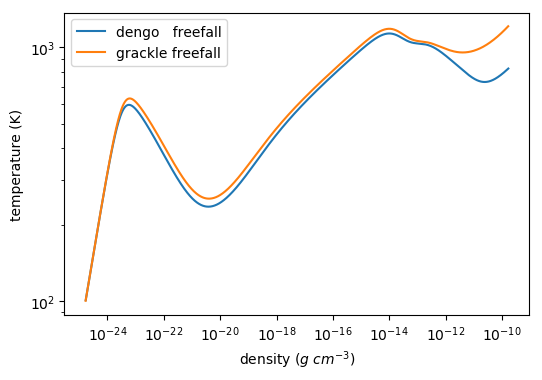

In [149]:
plt.figure(dpi=100)
plt.loglog(density_array[1:]* u.amu.v, all_data['T'] ,label='dengo   freefall')
plt.loglog(grackle_rho, grackle_T, label='grackle freefall')
plt.xlabel('density ($g$ $cm^{-3}$)')
plt.ylabel('temperature (K)')
plt.legend()

In [130]:
def get_e_from_all_data(all_data):
    l = len(all_data['de'])
    q = np.zeros((l))
    for sp in primordial.required_species:
        if sp.name not in ['ge', 'de']:
            q += numpy.array(all_data[sp.name])/ sp.weight * sp.free_electrons
    return q

def get_mu_from_all_data(all_data, density_array):
    l = len(all_data['de'])
    n = np.zeros((l))    
    # mass density / number density
    for sp in primordial.required_species:
        if sp.name not in ['ge', 'de']:
            n += numpy.array(all_data[sp.name])/ sp.weight
            
    mu = density_array/ n / 1.00794
    return mu

def get_gamma_from_all_data( all_data ):
    l = len(all_data['de'])
    total_n = np.zeros((l))    
    # mass density / number density
    for sp in primordial.required_species:
        if sp.name not in ['ge', 'de']:
            total_n += numpy.array(all_data[sp.name])/ sp.weight    

    rs = primordial.required_species
    H2_1_sp = list(rs)[0]
    
    gamma_array = np.zeros((l))
    for n in range(l):
        
        temperature = all_data['T'][n]
        num_den = {}
        for sp in primordial.required_species:
            if sp.name != 'ge':
                num_den[sp.name] = numpy.array(all_data[sp.name][n])/ sp.weight   

        gammaH2 = primordial.species_gamma(H2_1_sp,name=False, temp=True).subs({'T':temperature})    
        gamma_factor = primordial.gamma_factor().subs(num_den).subs({'gammaH2': gammaH2 , 
                                                                         'gamma': 5./3.,'T': temperature })
        # gamma_factor = n / (gamma - 1)
        
        gamma = total_n[n] / gamma_factor + 1.0
        gamma_array[n] = gamma
    return gamma_array

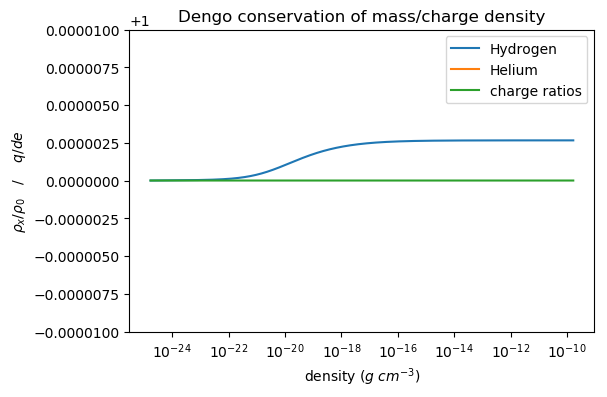

In [150]:
# check conservation of stuff
plt.figure(dpi = 100)
yerr = 1e-5
plt.ylim( 1- yerr ,  1+ yerr)
plt.title('Dengo conservation of mass/charge density')
plt.xlabel('density ($g$ $cm^{-3}$)')
plt.ylabel(r'$\rho_x / \rho_0$   /    $ q / de $')


all_H = numpy.array(all_data['H_1']) + numpy.array(all_data['H2_1']) + numpy.array(all_data['H2_2'])
plt.semilogx( density_array[1:]*u.amu, (all_H / density_array[1:]) / (all_H / density_array[1:])[0], label='Hydrogen' )



all_He = numpy.array(all_data['He_1']) + numpy.array(all_data['He_2']) + numpy.array(all_data['He_3'])
plt.semilogx( density_array[1:]*u.amu, (all_He / density_array[1:]) / (all_H / density_array[1:])[0], label='Helium' )




q = get_e_from_all_data(all_data)
de = numpy.array(all_data['de'])

plt.semilogx(density_array[1:]*u.amu, de /q, label='charge ratios' )

plt.legend()
plt.show()

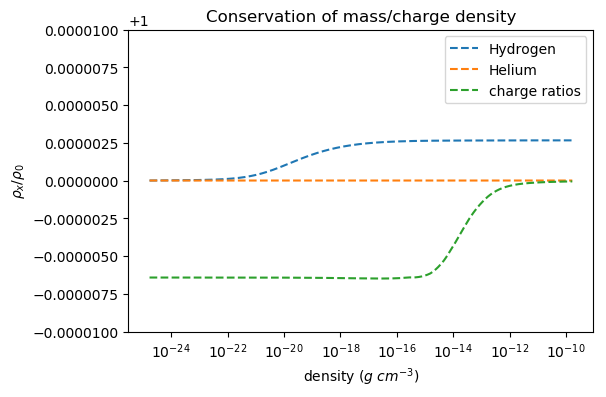

In [132]:
# check conservation of stuff
plt.figure(dpi = 100)
yerr = 1e-5
plt.ylim( 1- yerr ,  1+ yerr)
plt.title('Conservation of mass/charge density')
plt.xlabel('density ($g$ $cm^{-3}$)')
plt.ylabel(r'$\rho_x / \rho_0$')

plt.gca().set_prop_cycle(None)

all_H_gra = numpy.array(grackle_data['H_1']) + numpy.array(grackle_data['H2_1']) + numpy.array(grackle_data['H2_2'])
plt.semilogx( density_array[1:]*u.amu, (all_H_gra / density_array[1:]) / (all_H_gra / density_array[1:])[0], 
             label='Hydrogen', ls = '--' )



all_He_gra = numpy.array(grackle_data['He_1']) + numpy.array(grackle_data['He_2']) + numpy.array(grackle_data['He_3'])
plt.semilogx( density_array[1:]*u.amu, (all_He_gra/ density_array[1:]) / (all_He_gra / density_array[1:])[0], 
             label='Helium', ls = '--' )



def get_e_from_all_data(all_data):
    l = len(all_data['de'])
    q = np.zeros((l))
    for sp in primordial.required_species:
        if sp.name not in ['ge', 'de']:
            q += numpy.array(all_data[sp.name])/ sp.weight * sp.free_electrons
    return q

q = get_e_from_all_data(grackle_data)
de = numpy.array(grackle_data['de'])

plt.semilogx(density_array[1:]*u.amu, de /q / 1.00794, label='charge ratios', ls= '--' )

plt.legend()
plt.show()

<Figure size 600x400 with 0 Axes>

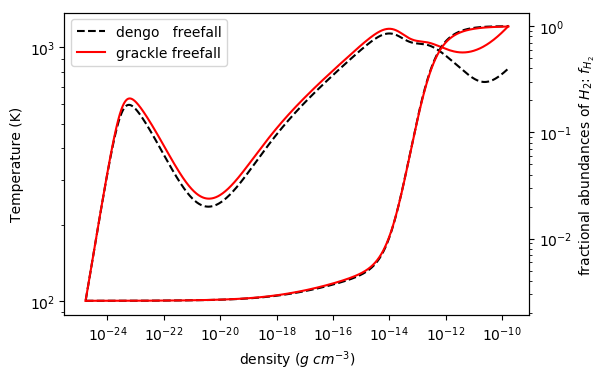

In [151]:
### get fractional abundances of H2
plt.figure(dpi =100)

fig, ax1 = plt.subplots(dpi =100)

ax2 = ax1.twinx()

ax1.loglog(density_array[1:]* u.amu.v, all_data['T'], label='dengo   freefall', color='k', ls='--')
ax1.loglog(grackle_rho, grackle_T, label='grackle freefall',color='r')
ax1.set_xlabel('density ($g$ $cm^{-3}$)')
ax1.set_ylabel('Temperature (K)')


ax2.set_ylabel('fractional abundances of $H_2$: $f_{H_2}$ ')
ax2.plot(density_array[1:]* u.amu.v, all_data['H2_1'] / all_H, label='dengo   freefall' ,color='k', ls='--')
ax2.loglog(density_array[1:]* u.amu.v, grackle_data['H2_1'] / all_H_gra, label='grackle  freefall' ,color='r')

ax1.legend()

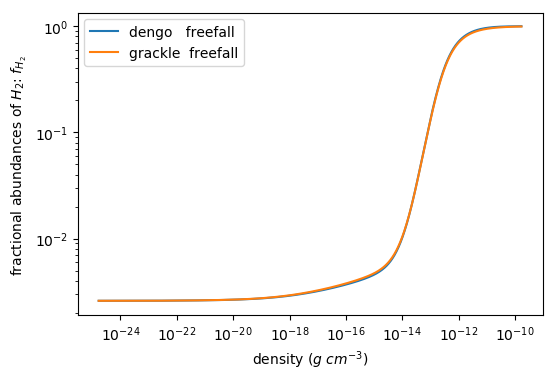

In [137]:
plt.figure(dpi=100)
plt.xlabel('density ($g$ $cm^{-3}$)')
plt.ylabel('fractional abundances of $H_2$: $f_{H_2}$ ')
plt.plot(density_array[1:]* u.amu.v, all_data['H2_1'] / all_H, label='dengo   freefall' )
plt.loglog(density_array[1:]* u.amu.v, grackle_data['H2_1'] / all_H_gra, label='grackle  freefall')
plt.legend()

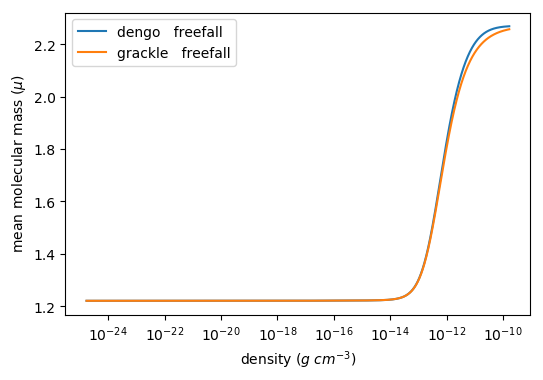

In [138]:
plt.figure(dpi =100)
plt.xlabel('density ($g$ $cm^{-3}$)')
plt.ylabel(' mean molecular mass ($\mu$) ')

mu_dengo = get_mu_from_all_data(all_data, density_array[1:])
mu_grackle = get_mu_from_all_data(grackle_data, density_array[:-1])


plt.plot(density_array[1:]* u.amu.v, mu_dengo, label='dengo   freefall' )
plt.semilogx(density_array[1:]* u.amu.v, mu_grackle , label='grackle   freefall' )
plt.legend()
plt.show()

In [139]:
gamma_dengo = get_gamma_from_all_data( all_data )
gamma_grackle = get_gamma_from_all_data( grackle_data )

KeyboardInterrupt: 

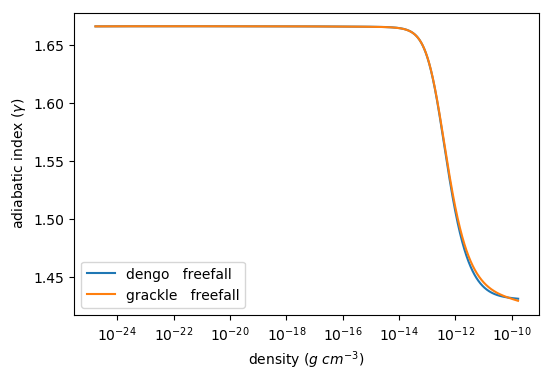

In [140]:
plt.figure(dpi =100)
plt.xlabel('density ($g$ $cm^{-3}$)')
plt.ylabel(' adiabatic index ($\gamma$) ')

plt.plot(density_array[1:]* u.amu.v, gamma_dengo, label='dengo   freefall' )
plt.semilogx(density_array[:-1]* u.amu.v, gamma_grackle , label='grackle   freefall' )

plt.legend()
plt.show()

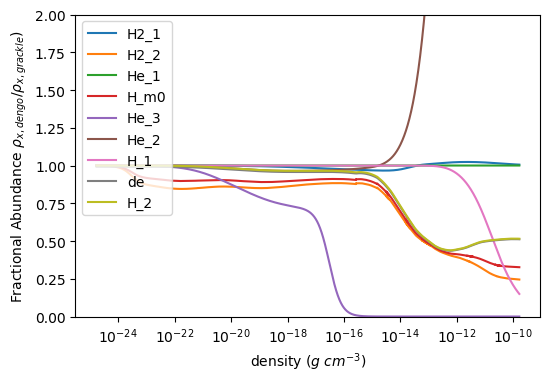

In [152]:
plt.figure(dpi=100)
for key in primordial.required_species:
    if key.name not in ['ge'] :
        plt.semilogx(density_array[1:-1]*u.amu, numpy.array(all_data[key.name][:-1] )/ grackle_data[ key.name ][1:],label=key.name )

plt.ylim(0, 2)
# plt.ylim(0.8,1.1)
# plt.xlim(1e-24,1e-22)
plt.legend( loc = 2)
plt.xlabel('density ($g$ $cm^{-3}$)')
plt.ylabel(r'Fractional Abundance $\rho_{x, dengo} / \rho_{x, grackle})$')
plt.title('')
plt.show()

KeyError: 'ge'

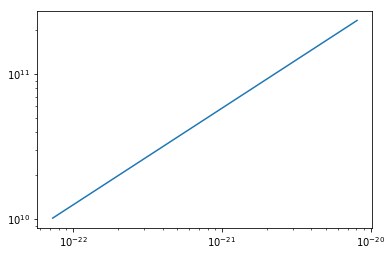

In [71]:
plt.loglog(density_array[2:-1]*u.amu, numpy.array(all_data['ge'][:-1] ),label='ge' )


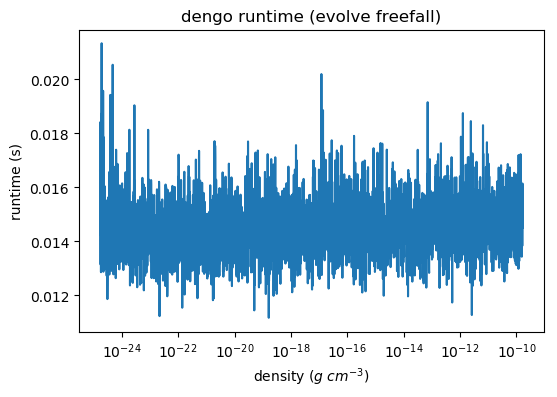

In [145]:
plt.figure(dpi = 100)
plt.semilogx(density_array[1:]* u.amu, run_time)
plt.xlabel('density ($g$ $cm^{-3}$)')
plt.ylabel('runtime (s)')
plt.title('dengo runtime (evolve freefall)')
plt.show()

In [20]:
f = h5py.File('test_bechem_cvdls_tables.h5')
f.keys()
f.close()

# Performance with N strips

In [32]:
%%writefile bechem_runfile
#!/bin/bash
rm -f a.out
g++ test_bechem_cvdls_solver.C test_bechem_cvdls_solver_main.C BE_chem_solve.C -I. -lm -lstdc++ -lhdf5 -lhdf5_hl -O3


Overwriting bechem_runfile


In [33]:
!bash bechem_runfile

In [34]:
!./a.out

Successfully read in rate tables.
Successfully read in cooling rate tables.
Successfully read in gamma tables.
Getting dimensionality from ge:
  ncells =   1
Reading I.C. for /H2_1
H2_1[0] = 1e-10, atol =>  1e-19
Reading I.C. for /H2_2
H2_2[0] = 1e-10, atol =>  1e-19
Reading I.C. for /H_1
H_1[0] = 7.6e+09, atol =>  1e-19
Reading I.C. for /H_2
H_2[0] = 1e-10, atol =>  1e-19
Reading I.C. for /H_m0
H_m0[0] = 1e-10, atol =>  1e-19
Reading I.C. for /He_1
He_1[0] = 2.4e+09, atol =>  1e-19
Reading I.C. for /He_2
He_2[0] = 1e-10, atol =>  1e-19
Reading I.C. for /He_3
He_3[0] = 1e-10, atol =>  1e-19
Reading I.C. for /de
de[0] = 1.25e-10, atol =>  1e-19
Reading I.C. for /ge
ge[0] = 2.02e+11, atol =>  1e-19
dt 0.76294, Sweep 0, Unsolved[0]: nchem: 0 change:  4.7592827e+36 sum tol:  4.7593e+27 atol:  1e-09 rtol:  1e-09 value: -4.7593e+36
dt 0.38147, Sweep 0, Unsolved[0]: nchem: 0 change:  4.7592827e+36 sum tol:  4.7593e+27 atol:  1e-09 rtol:  1e-09 value: -4.7593e+36
dt 0.19073, Sweep 0, Unsolved[

In [32]:
def cooling_rate_from_temp(T):
    cooling_rates = {}
    for action in primordial.cooling_actions.values():
        actionname = action.name
        for tab in action.tables:
            name = "{}_{}[i]".format(actionname, tab)
            
            temp_array = primordial.T
            
            cooling = numpy.interp(T, temp_array, action.tables[tab](primordial))
            cooling_rates[name] = cooling
    cooling_rates['T'] = T
    cooling_rates['z'] = numpy.zeros((len(T)))
#     cooling_rates = sorted(cooling_rates)
    return cooling_rates

def cooling_from_results(results, primordial, cooling_rates, T):
    
    cooling_results = {}

    for action in primordial.cooling_actions:
        cool_action = cooling_registry[action].equation
        cool_sym = cool_action.free_symbols
        
        cool_sym_name = [str(i) for i in cool_sym]
        func = lambdify(cool_sym, cool_action,'numpy') # returns a numpy-ready function
        
        
        num_var = len(cool_sym)
        len_T   = len(T)
        
        input_array = numpy.zeros(( num_var, len_T ))       
        for iii, sym_name in enumerate(cool_sym_name):
            try:
                input_array[iii, :] = results[sym_name]
            except:
                input_array[iii, :] = cooling_rates[sym_name]
        
        
        cooling_results[action] = func(*input_array)
    return cooling_results

In [33]:
T_array = all_data['T']

cooling_rates = cooling_rate_from_temp(T_array)
cooling_rates['mdensity'] = density_array[1:]
cooling_rates['mh'] = numpy.ones((len(T_array)))* u.mass_hydrogen_cgs.v

cooling_results = cooling_from_results(all_data, primordial, cooling_rates, T_array)


T_array_gra = grackle_data['T']

cooling_rates_gra = cooling_rate_from_temp(T_array_gra)
cooling_rates_gra['mdensity'] = density_array[1:]
cooling_rates_gra['mh'] = numpy.ones((len(T_array_gra)))* u.mass_hydrogen_cgs.v

cooling_results_gra = cooling_from_results(grackle_data, primordial, cooling_rates_gra, T_array_gra)

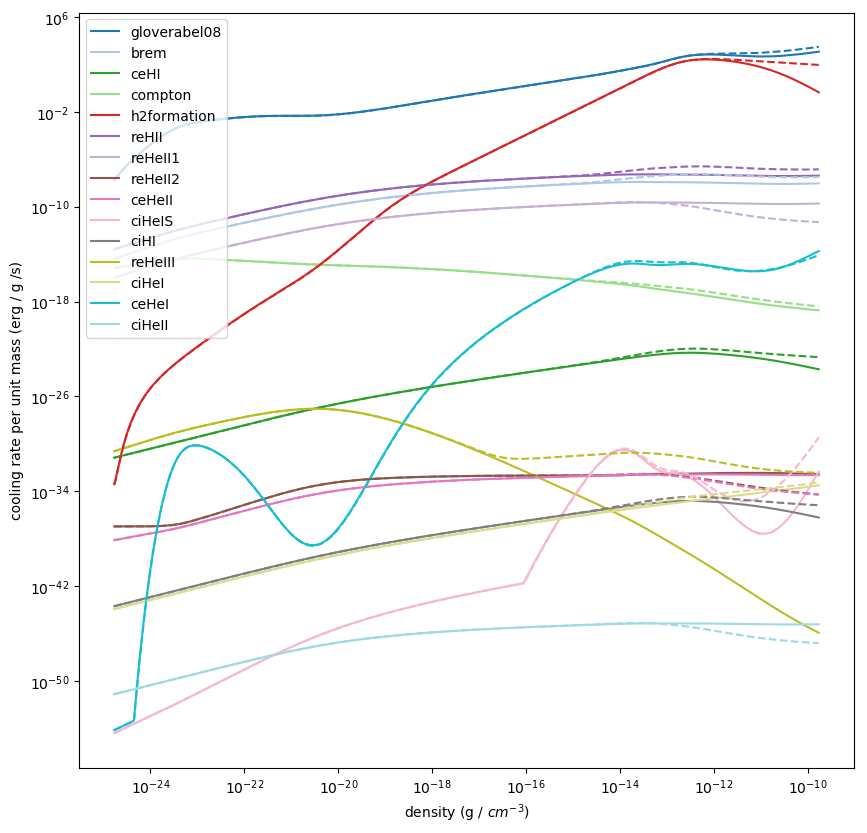

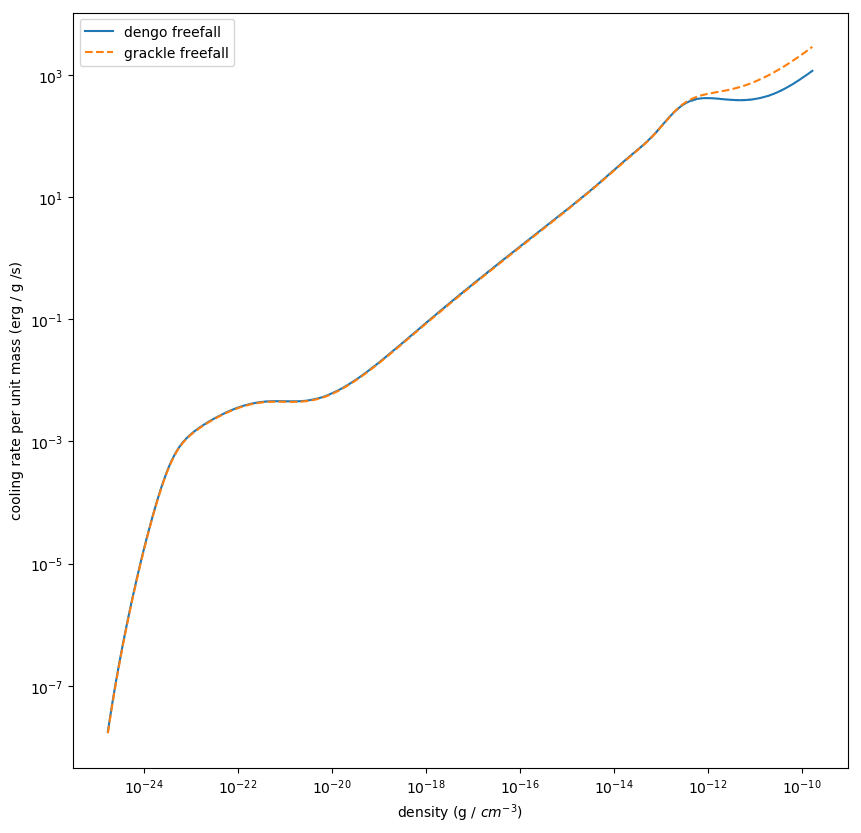

In [42]:
plt.figure(dpi=100, figsize=(10,10))
from matplotlib.pyplot import cm
color=cm.tab20(np.linspace(0,1,len(cooling_results.keys()) ))
net_cooling = numpy.zeros((len(T_array)))

iii = 0
for i in cooling_results.keys():
    d = cooling_results[i]
    
    net_cooling = d + net_cooling
    if i not in ['gammah']:
        if d[0] < 0:
            plt.semilogx(density_array[1:]*u.amu, numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i,c=color[iii])
        else:
            plt.loglog(density_array[1:]*u.amu, numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i,  c=color[iii])
            
    iii += 1
    
net_cooling_gra = numpy.zeros((len(T_array_gra)))

iii = 0
for i in cooling_results_gra.keys():
    d = cooling_results_gra[i]
    
    net_cooling_gra = d + net_cooling_gra
    if i not in ['gammah']:
        if d[0] < 0:
            plt.semilogx(density_array[1:]*u.amu, numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, ls= '--', c=color[iii])
        else:
            plt.loglog(density_array[1:]*u.amu, numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, ls= '--', c=color[iii])
            
    iii += 1    

plt.legend()
plt.xlabel('density (g / $cm^{-3}$)')
plt.ylabel(r'cooling rate per unit mass (erg / g /s)')
# plt.ylim(1e-5,1e5)
plt.gca().set_prop_cycle(None)


plt.show()

plt.figure(dpi=100, figsize=(10,10))
plt.loglog(density_array[1:]*u.amu, numpy.abs(net_cooling)/density_array[1:]/ u.amu_cgs.v, label='dengo freefall')
plt.loglog(density_array[1:]*u.amu, numpy.abs(net_cooling_gra)/density_array[1:]/ u.amu_cgs.v,ls= '--',label='grackle freefall')
# plt.ylim(1e-5,1e5)
plt.legend()
plt.xlabel('density (g / $cm^{-3}$)')
plt.ylabel(r'cooling rate per unit mass (erg / g /s)')
plt.show()